In [6]:
%matplotlib inline

import gym
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import sys
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict
# if "../" not in sys.path:
#   sys.path.append("../") 
from blackjack_fromgit import BlackjackEnv
#from plotting_fromgit import plot_value_function
from blackjack_env import Simple21
from surface_plot import plottable_3d_info

matplotlib.style.use('ggplot')


#keep track of these
#https://ernie55ernie.github.io/assets/blackjack.html
#https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/blackjack.py
#https://stackoverflow.com/questions/36589521/how-to-surface-plot-3d-plot-from-dataframe
#


In [3]:
#env = BlackjackEnv()
env = Simple21()



In [11]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


def get_epsilon(N):
    N_0 = 100
    return N_0/(N_0 + N)

def epsilon_greedy_policy(Q, N, state):
    player, dealer = state
    epsilon = get_epsilon(np.sum(N[player-1, dealer-1]))
    if np.random.rand() < (1 - epsilon):
        action = np.argmax(Q[player-1, dealer-1, :])
    else:
        action = np.random.choice([0,1])
    return action



def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = np.zeros((21,10,2)) 
    returns_count = np.zeros((21,10,2))
    state_counts = np.zeros((21,10))

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    #Q = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = np.zeros((21,10,2))
    # The policy we're following
    #policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        #print("episode #: ",i_episode)
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        #print("state: ", state)
        while True:
            action = epsilon_greedy_policy(Q,state_counts,state)#policy(state)
            #action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            # print('next_state:', next_state)
            # print('reward:', reward)
            # print('done:', done)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
       # print('sa_in_episode:', sa_in_episode)
        for state, action in sa_in_episode:
            #state = (state[0] - 1,state[1] - 1)
            #sa_pair = (state, action)
            #sa_pair[0] = (sa_pair[0][0]-1, sa_pair[0][1] -1)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])  #G is the expected reward
            # Calculate average return for this state over all sampled episodes
            state = (state[0] - 1,state[1] - 1)
            #sa_pair = (state, action)
            returns_sum[state][action] += G
            returns_count[state][action] += 1.0 #return_counts[state][action]
            state_counts[state] += 1.0
            Q[state][action] =+ (returns_sum[state][action] - Q[state][action]) / returns_count[state][action]
        
        #print("reward: ",reward)
        # The policy is improved implicitly by changing the Q dictionary
    
    return Q #, policy

In [12]:


Q = mc_control_epsilon_greedy(env, num_episodes=50000, epsilon=0.1)



Episode 50000/50000.

In [6]:
Q[:,0]

array([[-1.        ,  0.        ],
       [-0.5       , -0.5       ],
       [-0.83333333, -0.79166667],
       [-0.63194444, -0.84166667],
       [-0.175     , -0.10734127],
       [-0.58644313, -0.01733631],
       [-0.36925292, -0.1839203 ],
       [-0.54946511,  0.00749304],
       [ 0.31340375, -0.422777  ],
       [-0.5491234 ,  0.56145833],
       [-0.48440531, -0.17173143],
       [-0.5141095 , -0.68663794],
       [-0.50999557, -0.33564566],
       [-0.37114303, -0.35491409],
       [-0.45049698, -0.57074288],
       [-0.52228185, -0.68198542],
       [-0.16231717, -0.44907282],
       [-0.07422088, -0.6831198 ],
       [ 0.42610828, -0.54887107],
       [ 0.71125679, -0.66725814],
       [ 0.82642851, -0.80812538]])

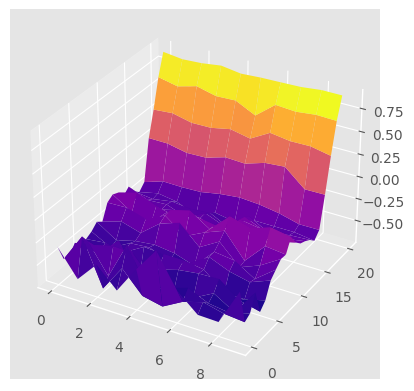

In [13]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
#V = defaultdict(float)
#for state, actions in Q.items():
#    action_value = np.max(actions)
#    V[state] = action_value
    

#surface=pd.DataFrame.from_dict(V, orient= 'index')
#surface = surface.reset_index()
#surface['Index'] = (surface['index'].apply(lambda x:x[1]))
#surface['Column']=surface['index'].apply(lambda x: x[0])
##surface=pd.pivot_table(surface,index='Index',columns='Column',values=0).fillna(0)
#V

x, y, z, xticks, yticks = plottable_3d_info(pd.DataFrame(np.max(Q,2).T))

### Set up axes and put data on the surface.
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
axes.plot_surface(y, x, z,cmap='plasma')

### Customize labels and ticks (only really necessary with
### non-numeric axes).
# axes.set_xlabel('material')
# axes.set_ylabel('shape')
# axes.set_zlabel('USD per item')
# axes.set_zlim3d(bottom=0)
#plt.xticks(**xticks)
#plt.yticks(**yticks)

plt.show()

In [8]:
pd.DataFrame(np.max(Q,2)).T

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.000000,-0.500000,-0.791667,-0.631944,-0.107341,-0.017336,-0.183920,0.007493,0.313404,0.561458,...,-0.514109,-0.335646,-0.354914,-0.450497,-0.522282,-0.162317,-0.074221,0.426108,0.711257,0.826429
1,0.000000,-0.291667,-0.125000,-0.147817,-0.581944,-0.430965,-0.307504,0.064679,-0.504908,-0.064585,...,-0.529822,-0.376845,-0.475841,-0.453032,-0.408570,-0.253288,0.051406,0.323678,0.571611,0.815075
2,0.000000,-0.833333,0.031944,-0.346230,-0.452516,-0.237426,-0.586412,-0.877183,-0.526389,-0.464788,...,-0.369893,-0.540353,-0.538967,-0.460621,-0.520459,-0.428440,-0.104049,0.472905,0.787103,0.742250
3,0.000000,-0.500000,0.034722,-0.526389,-0.833333,-0.243056,-0.311026,-0.312500,-0.525380,-0.625675,...,-0.324907,-0.567974,-0.526824,-0.432745,-0.381111,-0.328500,-0.041278,0.386777,0.652342,0.907028
4,-0.166667,-0.166667,-0.441667,-0.458333,-0.018477,-0.549520,-0.259881,-0.573989,-0.257372,-0.508333,...,-0.293643,-0.471858,-0.571481,-0.449192,-0.480443,-0.467320,0.054974,0.545560,0.666199,0.769584
5,-0.833333,-0.166667,-0.458333,-0.525000,-0.312500,-0.579167,-0.375000,-0.201761,-0.505327,-0.129274,...,-0.360704,-0.368896,-0.430058,-0.412011,-0.355021,-0.308533,0.088591,0.228311,0.576158,0.911843
6,-0.500000,0.041667,-0.541667,-0.306920,-0.239154,-0.877183,-0.564304,-0.449465,-0.144866,-0.669020,...,-0.465880,-0.506968,-0.417436,-0.452879,-0.489642,-0.224690,0.131376,0.381111,0.500146,0.866819
7,0.500000,-0.683333,-0.346230,-0.668236,-0.790084,-0.564975,-0.361579,0.058580,-0.382416,-0.459309,...,-0.379983,-0.476215,-0.416038,-0.434328,-0.503846,-0.404570,0.234530,0.322764,0.600135,0.893666
8,0.000000,-0.385119,-0.841667,-0.631151,-0.187607,-0.663673,-0.591468,-0.259722,-0.535529,-0.361568,...,-0.449953,-0.344311,-0.499952,-0.545486,-0.512581,-0.333126,0.056123,0.561541,0.690655,0.875126
9,-0.500000,-0.841667,-0.541667,-0.525379,-0.703216,-0.422777,-0.383532,-0.451959,-0.353373,-0.255537,...,-0.492675,-0.484902,-0.365707,-0.627757,-0.500040,-0.275688,0.054815,0.146211,0.622054,0.931854
